In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt

from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, Input, GlobalAveragePooling2D, Dense, Add, Flatten

from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

2024-05-27 07:44:46.374591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 07:44:46.374728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 07:44:46.513914: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [4]:
base_dir = '/kaggle/input/fruit-and-vegetable-image-recognition'

In [5]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [7]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 36
number of classes in validation folder : 36
number of classes in test folder : 36


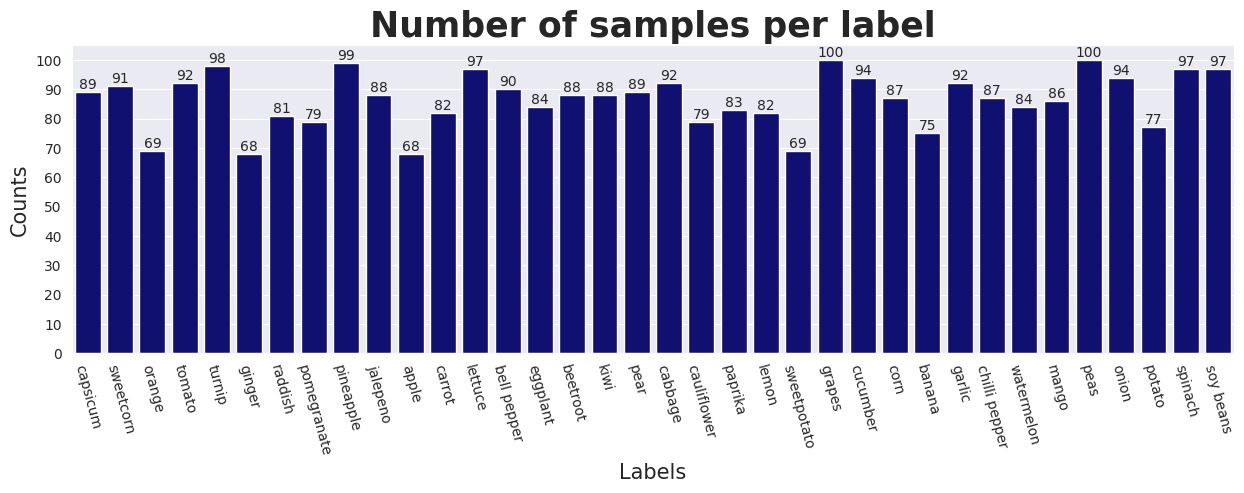

In [8]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

In [9]:
def create_df(folder_path) :
    all_images = []    
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [10]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [11]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 3115
Number of samples in validation : 351
Number of samples test : 359


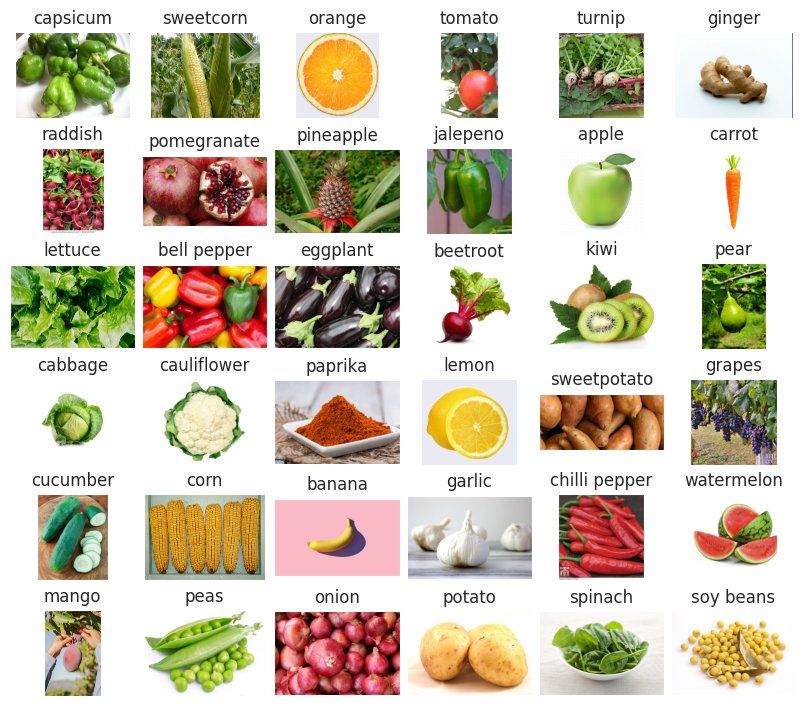

In [12]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,                  
    shuffle=True,
    seed=42,
    
)

Found 3115 validated image filenames belonging to 36 classes.


In [14]:
validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 351 validated image filenames belonging to 36 classes.


In [15]:
test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 359 validated image filenames belonging to 36 classes.


In [21]:
def expansion_block(x,t,filters,block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filters = t*filters
    x = Conv2D(total_filters,1,padding='same',use_bias=False, name =    prefix +'expand')(x)
    x = BatchNormalization(name=prefix +'expand_bn')(x)
    x = ReLU(6,name = prefix +'expand_relu')(x)
    return x

In [22]:
def depthwise_block(x,stride,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3,strides=(stride,stride),padding ='same', use_bias = False, name = prefix + 'depthwise_conv')(x)
    x = BatchNormalization(name=prefix +'dw_bn')(x)
    x = ReLU(6,name = prefix +'dw_relu')(x)
    return x

In [23]:
def projection_block(x,out_channels,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters=out_channels,kernel_size = 1,   padding='same',use_bias=False,name= prefix + 'compress')(x)
    x = BatchNormalization(name=prefix +'compress_bn')(x)
    return x

In [24]:
def Bottleneck(x,t,filters, out_channels,stride,block_id):
    y = expansion_block(x,t,filters,block_id)
    y = depthwise_block(y,stride,block_id)
    y = projection_block(y, out_channels,block_id)
    if y.shape[-1]==x.shape[-1]:
       y = Add()([x, y])
    return y

In [25]:
def MobileNetV2(input_shape = (224,224,3)):
    input = Input (input_shape)
    x = Conv2D(32,3,strides=(2,2),padding='same', use_bias=False)(input)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name='conv1_relu')(x)
    # 17 Bottlenecks
    x = depthwise_block(x,stride=1,block_id=1)
    x = projection_block(x, out_channels=16,block_id=1)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 2,block_id = 2)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 3)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 4)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 5)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 6)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 2,block_id = 7)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 8)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 9)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 10)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 11)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 12)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 13)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 2,block_id = 14)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 15)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 16)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 320, stride = 1,block_id = 17)
    x = Conv2D(filters = 1280,kernel_size = 1,padding='same',use_bias=False, name = 'last_conv')(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)
    x = GlobalAveragePooling2D(name='global_average_pool')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(36,activation='softmax')(x)
    model = Model(input, output)
    return model

In [26]:
model = MobileNetV2()

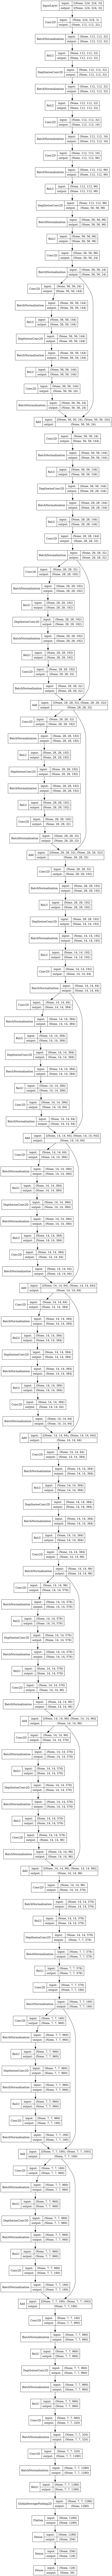

In [27]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [28]:
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv2d_1[0][0]']            
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']        

In [29]:
# Compile 
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

In [30]:
for file in os.listdir('/kaggle/working')[:]:
    if file == '.virtual_documents':
        continue
    os.remove(os.path.join('/kaggle/working', file))

In [31]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True) 

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [32]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/100


I0000 00:00:1716796184.674085     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 [==============================] - 196s 2s/step - loss: 3.3790 - accuracy: 0.0770 - val_loss: 3.7201 - val_accuracy: 0.0285 - lr: 0.0010
Epoch 2/100
13/98 [==>...........................] - ETA: 1:34 - loss: 3.0417 - accuracy: 0.1370

KeyboardInterrupt: 

In [39]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

loss  accuracy  val_loss  val_accuracy        lr
95  0.884213  0.714928  0.411862      0.863248  0.000002
96  0.882336  0.713002  0.411378      0.866097  0.000001
97  0.908832  0.709791  0.414393      0.860399  0.000001
98  0.874450  0.716212  0.413291      0.863248  0.000001
99  0.855208  0.725843  0.413502      0.863248  0.000001

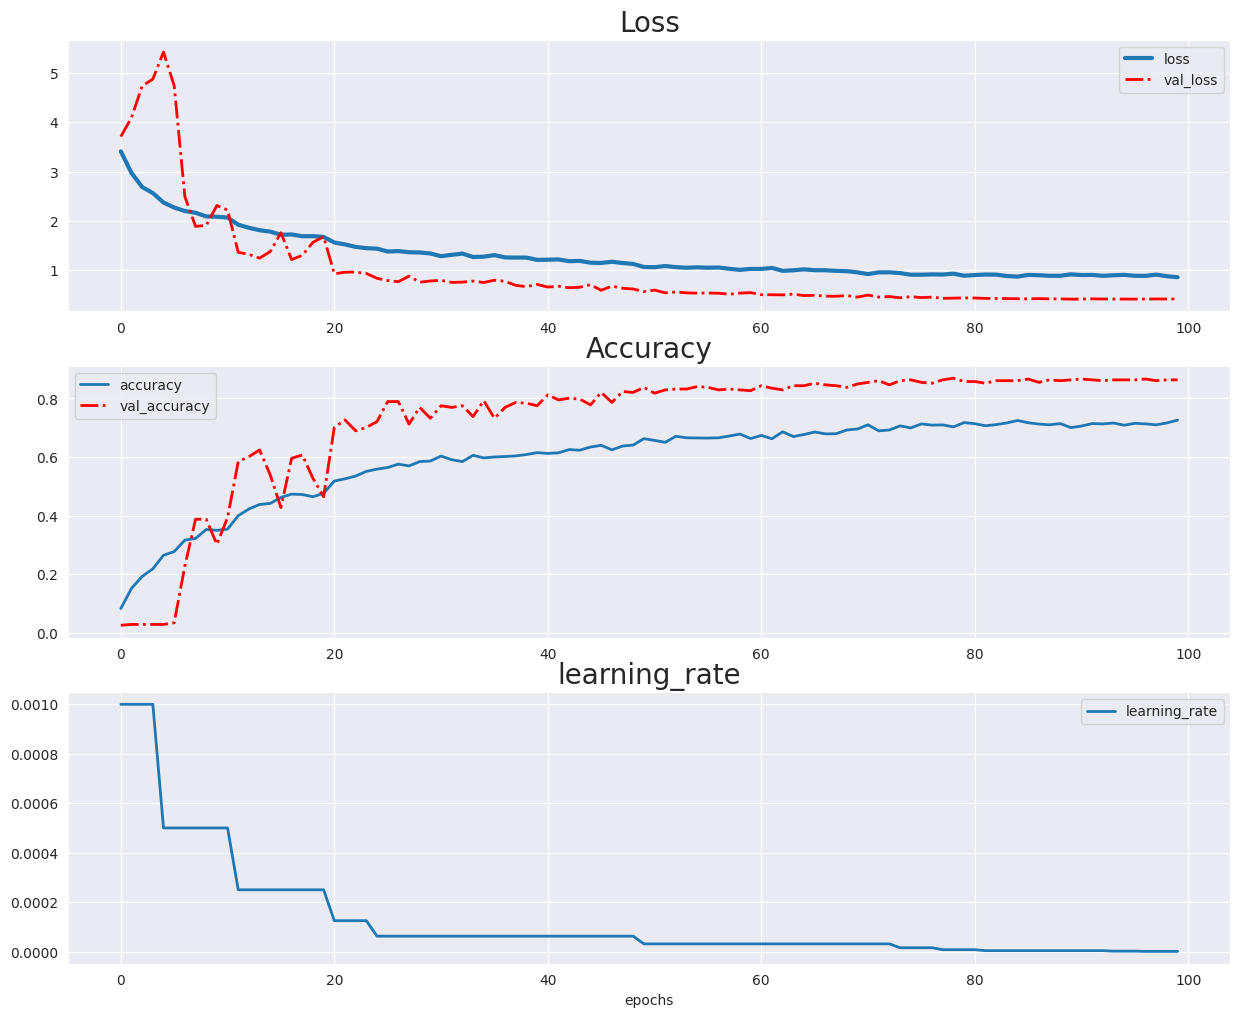

In [40]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.lr, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

In [41]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it
best_model = load_model('MyModel.keras')

In [42]:
test_loss, test_acc = best_model.evaluate_generator(test_generator)

print(colored(f'Test Loss : {round(test_loss, 3)}', 'green', attrs=['bold']))
print(colored(f'Test Accuracy : {round(test_acc, 3)}', 'green', attrs=['bold']))

Test Loss : 0.412
Test Accuracy : 0.864


In [43]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

11/11 [==============================] - 11s 934ms/step
               precision    recall  f1-score   support

        apple       0.78      0.70      0.74        10
       banana       1.00      0.78      0.88         9
     beetroot       0.83      1.00      0.91        10
  bell pepper       0.62      0.56      0.59         9
      cabbage       1.00      0.90      0.95        10
     capsicum       0.54      0.70      0.61        10
       carrot       1.00      1.00      1.00         9
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.73      0.89      0.80         9
         corn       1.00      0.10      0.18        10
     cucumber       0.83      1.00      0.91        10
     eggplant       1.00      0.90      0.95        10
       garlic       0.83      1.00      0.91        10
       ginger       1.00      0.80      0.89        10
       grapes       1.00      0.89      0.94         9
     jalepeno       1.00      0.67      0.80         9
        

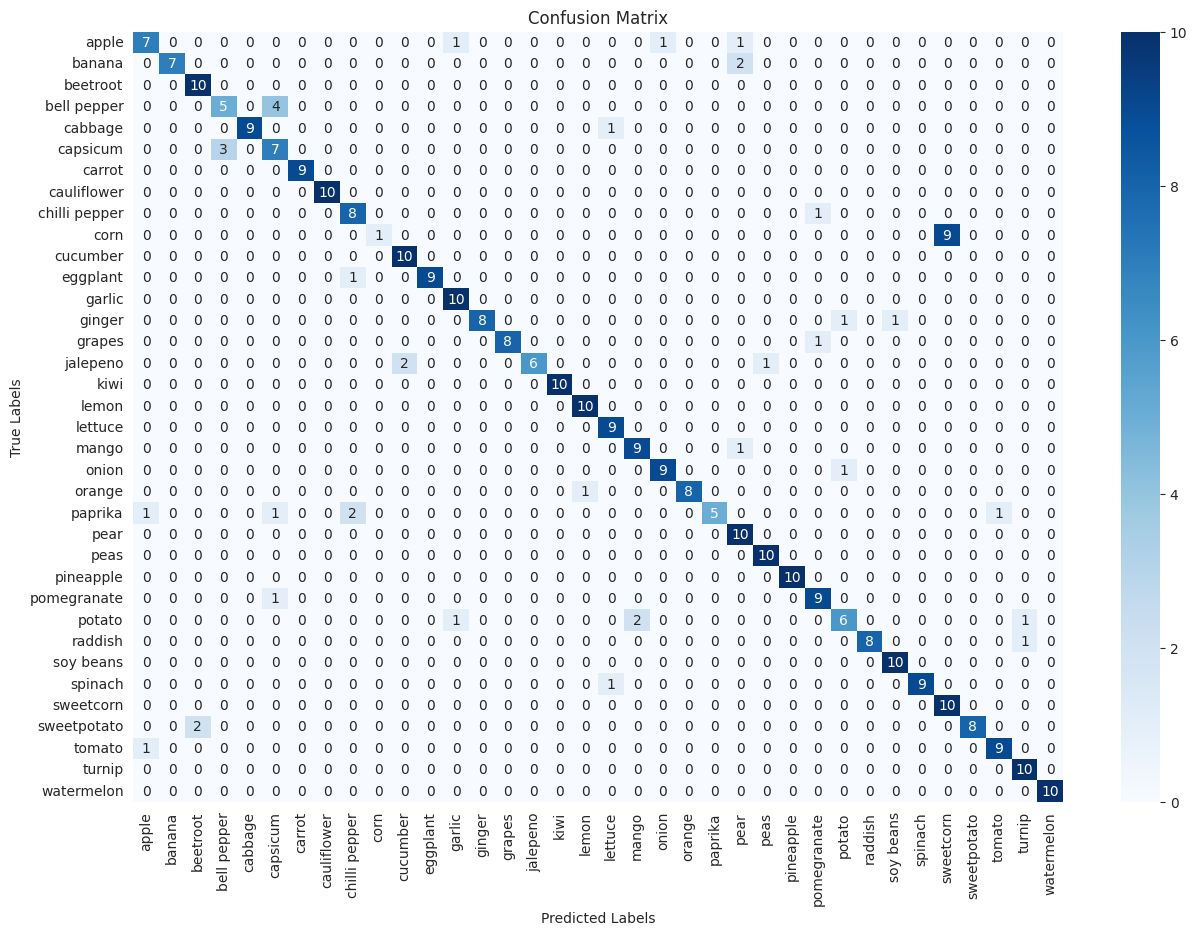

In [44]:
evaluate_model_performance(best_model, validation_generator, classes)